## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

## 2  — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve each idiom containing the word.
Add the idiom Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-idiom match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


## 5 — Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10 and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [1]:
test_image_topic=  'two'
image_topic = test_image_topic

In [2]:
import pandas as pd
from collections import namedtuple
import uuid

## -1  — Webscrape and process phrases (idioms, sayings, aphorisms)

They should be converted into lists of phonetic sounds

## 0  — Load `phrase_dict` pickled and processed after being scraped

#### Data structures defined

In [3]:

Phrase = namedtuple('Phrase',['text_string', 'word_list','phon_list','string_length', 'word_count', 'prefix', 'phrase_type'])
phrase_dict = dict()

Close_word = namedtuple('Close_word', ['word', 'distance'])

Sem_family = namedtuple('Sem_family', ['locus_word', 'sem_fam_words'])

Phon_family = namedtuple('Phon_family', ['locus_word', 'close_words'])

#### Temporary toy example of the dict of phrases, to be replaced with idioms etc. scraped from web

In [4]:
t_string = 'Smarter than the average bear'
w_list = t_string.lower().split()
ph_id1 = uuid.uuid1()
phrase_dict[ph_id1] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

# toy example of the dict
t_string = 'Not a hair out of place'
w_list = t_string.lower().split()
ph_id2 = uuid.uuid1()
phrase_dict[ph_id2] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

# toy example of the dict
t_string = 'Three blind mice'
w_list = t_string.lower().split()
ph_id3 = uuid.uuid1()
phrase_dict[ph_id3] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

# toy example of the dict
t_string = 'I just called to say I love you'
w_list = t_string.lower().split()
ph_id3 = uuid.uuid1()
phrase_dict[ph_id3] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

t_string = 'Up, up in the air'
w_list = t_string.lower().split()
ph_id1 = uuid.uuid1()
phrase_dict[ph_id1] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

t_string = 'Wouldn\'t it be nice'
w_list = t_string.lower().split()
ph_id1 = uuid.uuid1()
phrase_dict[ph_id1] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

t_string = 'Roses are red, violets are blue'
w_list = t_string.lower().split()
ph_id1 = uuid.uuid1()
phrase_dict[ph_id1] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )



## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions


%matplotlib inline

In [6]:
def prepare_image_classification_model():
    model_ = tf.keras.applications.xception.Xception(weights = 'imagenet', include_top=True)
    return model_

import requests
def get_image_category_labels():  # is this function even necessary?
    #fetching labels from Imagenet
    response=requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
    imgnet_map=response.json()
    imgnet_map   # {'0': ['n01440764', 'tench'],   '1': ['n01443537', 'goldfish'], etc.
    
    imgnet_num_from_label = {v[1]:k for k, v in imgnet_map.items()}
    imgnet_label_from_num = {k:v[1] for k, v in imgnet_map.items()}

    return ( imgnet_num_from_label, imgnet_label_from_num ) 


In [7]:
def get_num_str( num, max_digits=4 ):
    leading_zeros = int(max_digits - (np.trunc(np.log10(num))+1))
    return '0'*leading_zeros + str(num)

In [8]:
import random

def get_image_path():
    path_prefix = 'data/ILSVRC/Data/DET/test/'
    filename_stem ='ILSVRC2017_test_0000'
    filename_suffix = '.JPEG'
    random.seed()
    file_number = rand_num = random.randint(1, 5500)   
    IMAGE_PATH_ = path_prefix + filename_stem + get_num_str( rand_num ) + filename_suffix
    return IMAGE_PATH_
    
def preprocess_image( IMAGE_PATH_ ):
    img_ =tf.keras.preprocessing.image.load_img(IMAGE_PATH_, target_size=(299, 299))
    img_ =tf.keras.preprocessing.image.img_to_array(img_)
    # view the image
    plt.imshow(img_/255.)
    return img_

def process_and_classify_image( img_, model_):
    img_ = tf.keras.applications.xception.preprocess_input(img_)
    print( 'img.shape: ', img_.shape )
    prediction_array = model_.predict(np.array([img_]))
    return prediction_array

def extract_best_prediction( prediction_array_ ):
    prediction_decoded = decode_predictions(prediction_array_, top=5)
    print( prediction_decoded )
    best_prediction_str = prediction_decoded[0][0][1]
    return best_prediction_str
    

In [9]:
global_var_img = None

def image_recognition_pipeline( ):
    model = prepare_image_classification_model()
    get_image_category_labels()
    IMAGE_PATH = get_image_path()
    img = preprocess_image( IMAGE_PATH )
    prediction_array = process_and_classify_image( img, model)
    image_topic_ = extract_best_prediction( prediction_array )
    global_var_img = img
    return  img, image_topic_,

img.shape:  (299, 299, 3)
[[('n02077923', 'sea_lion', 0.98271227), ('n02444819', 'otter', 0.0130150225), ('n02058221', 'albatross', 0.00015411079), ('n02441942', 'weasel', 0.00015190309), ('n02134084', 'ice_bear', 0.000121506244)]]


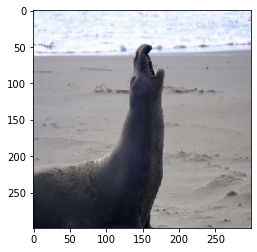

In [10]:
recognized_image, image_topic  = image_recognition_pipeline( )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


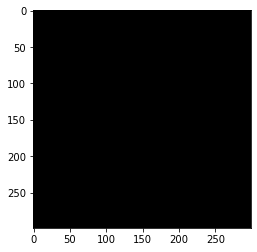

In [11]:
plt.imshow(recognized_image/255.)

## 2 — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

In [12]:
from nltk.corpus import wordnet

def get_synonyms( w ):
    return [l.name() for l in wordnet.synsets( w )[0].lemmas()]  # There may be other synonyms in the synset


## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

In [13]:
english_dictionary = ['two', 'pair', 'bear', 'scare', 'you', 'twice', 'hair', 'mice', 'speaker', 'book']

In [14]:
# two_phon_fam = Phon_family(locus_word=Close_word('two', 3), close_words = [Close_word('you', 2.1)])
# two_phon_fam

# pair_phon_fam = Phon_family(locus_word=Close_word('pair', 5), close_words = [Close_word('bear', 1.5), Close_word('hair', 2.7)])
# pair_phon_fam

# twice_phon_fam = Phon_family(locus_word=Close_word('twice', 4.1), close_words = [Close_word('mice', 2.1)])
# twice_phon_fam

In [15]:
from nltk.corpus import words

words_set = set( words.words())

In [16]:
import eng_to_ipa as ipa

def syllable_count_diff( w1, w2 ):
    return abs( ipa.syllable_count( w1 ) - ipa.syllable_count( w2 ))

def same_syllable_count( w1, w2 ):
    return syllable_count_diff(w1, w2) == 0

def close_syllable_count( w1, w2, threshold=1):
    return syllable_count_diff( w1, w2 ) <= threshold

In [17]:
# Eventually will need to to filter for the word-frequency sweet-spot or at least for only Engllish words
# Possibly rewrite with a decororater so that it uses memoization to speed this up

# Rewrite this so it vectorizes the subtraction of the syllable counts

def get_sized_rhymes( w ):
    word_length_min = 2
    rhyme_list = ipa.get_rhymes( w )
    return [ [rhyme for rhyme  in rhyme_list if same_syllable_count( w, rhyme) and len(rhyme) >= word_length_min and rhyme in words_set]]
   

In [18]:
ipa.isin_cmu('xue')

True

In [19]:
#get_sized_rhymes('two')

In [20]:
## Temporary stand-in function, to be replaced with one that computes phonetic distance

# https://stackabuse.com/phonetic-similarity-of-words-a-vectorized-approach-in-python/
# "Phonetic Similarity of Words: A Vectorized Approach in Python"

def lev_dist( phon1, phon2 ):
    return 100

In [21]:
from random import random


# Are these three lines necessary?
two_fam_member_list = ['you']
pair_fam_member_list = ['bear', 'hair']
twice_fam_member_list = ['mice']

def make_phon_fam_for_sem_fam_member( w_record, thresh=.2 ):
    w_phon_code = w_record.word # To be replaced with phonetic version if needed
    close_word_list = []
    
    # Find words that are not necessarily rhyms but phonetically similar
    for word in english_dictionary:
        word_phon_code = word
        dist = lev_dist(w_phon_code, word_phon_code)
        if dist < thresh:
            close_word_list.append( Close_word(word, dist) )
    
    rhyme_dist = .1 + random()/10
    rhyme_word_list = get_sized_rhymes( w_record.word )[0]
    
    # Find words that are rhymes
    for word in rhyme_word_list:
         close_word_list.append( Close_word(word, rhyme_dist) )
    
    
    return Phon_family(locus_word = w_record, close_words=close_word_list )
    
    

In [22]:
# two_phon_fam = get_phon_fam_for_sem_fam_member( 'two' )
# pair_phon_fam = get_phon_fam_for_sem_fam_member( 'pair' )
# twice_phon_fam = get_phon_fam_for_sem_fam_member( 'twice' )


In [23]:
## ALERT:  Need to incorporate the semantic distance somewhere

In [24]:
# two_sem_fam = Sem_family(locus_word='two', phon_fams = [make_phon_fam_for_sem_fam_member( 'two' ), \
#                                                         make_phon_fam_for_sem_fam_member( 'pair' ), \
#                                                         make_phon_fam_for_sem_fam_member( 'twice' )])

In [25]:
# To be replaced with Word2Vec `most_similar()`

def get_most_similar_obsolete( w ):  
    list_of_duples =  [('pair', .95), ('twice', .90)]
    list_of_close_words = [Close_word( word=w_str, distance= 1 - w_sim) for w_str, w_sim in list_of_duples ]
        
    return list_of_close_words

In [26]:
def get_most_similar( w ):  
    list_of_duples = [(syn, 1) for syn in get_synonyms( w )]
    if(w == 'two'):
        additional_words =  [('pair', .95), ('twice', .90)]
        list_of_duples.extend( additional_words )
    list_of_close_words = [Close_word( word=w_str, distance= 1 - w_sim) for w_str, w_sim in list_of_duples ]
        
    return list_of_close_words

In [27]:
#get_most_similar( 'three' )

In [28]:
def make_phon_fams_and_sem_family( w ):
    word_record_ = Close_word(w, 0.0)
    
    sem_sim_words = get_most_similar( w )  # Eventually replace with call to Word2Vec
    
    #phon_fams_list = [make_phon_fam_for_sem_fam_member( word_record_  )]
    phon_fams_list = []

    
    for close_w_record in sem_sim_words:
        print( close_w_record )
        phon_fams_list.append( make_phon_fam_for_sem_fam_member( close_w_record ) )
    
    return Sem_family(locus_word= word_record_, sem_fam_words = phon_fams_list)
   
 

In [29]:
two_sem_fam = make_phon_fams_and_sem_family('two')
two_sem_fam

Close_word(word='two', distance=0)
Close_word(word='2', distance=0)
Close_word(word='II', distance=0)
Close_word(word='deuce', distance=0)
Close_word(word='pair', distance=0.050000000000000044)
Close_word(word='twice', distance=0.09999999999999998)


Sem_family(locus_word=Close_word(word='two', distance=0.0), sem_fam_words=[Phon_family(locus_word=Close_word(word='two', distance=0), close_words=[Close_word(word='blue', distance=0.1054133153838313), Close_word(word='boo', distance=0.1054133153838313), Close_word(word='brew', distance=0.1054133153838313), Close_word(word='chew', distance=0.1054133153838313), Close_word(word='clue', distance=0.1054133153838313), Close_word(word='coo', distance=0.1054133153838313), Close_word(word='coup', distance=0.1054133153838313), Close_word(word='crew', distance=0.1054133153838313), Close_word(word='cue', distance=0.1054133153838313), Close_word(word='dew', distance=0.1054133153838313), Close_word(word='do', distance=0.1054133153838313), Close_word(word='drew', distance=0.1054133153838313), Close_word(word='due', distance=0.1054133153838313), Close_word(word='ewe', distance=0.1054133153838313), Close_word(word='few', distance=0.1054133153838313), Close_word(word='flew', distance=0.1054133153838313)

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve phrases containing the word.
Add the phrase_Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-phrase match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


## TO CODE NEXT

Write code that takes the word `twice` and returns its `semantic_family` which is a list of words 
('pair', and 'twice' in this case) and returns either (TBD) the list phonetically similar words or 
the pboneticized version of the word to be compared with the phoneticized variants of words in
the phrases



#### Define dataframe for candidate phrases

In [30]:
col_names = ['semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist', 'phrase_id', 'score']

cand_df = pd.DataFrame(columns= col_names)
cand_df

,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,score


#### Need to write body of function that will convert to phoneticized version of word

In [31]:
def phoneticized( w ):
    return w

### ALERT:  Instead, pre-generate a dictionary of phoneticized versions of the words in the list of idioms. Each phonetic word should map to a list of duples each of which is a phrase id and the corresponding word

In [32]:
def get_matching_phrases( w ):
    matched_id_list = []
    for phrase_id in phrase_dict.keys():
        if w in phrase_dict[phrase_id].phon_list:
            matched_id_list.append(phrase_id)
    return matched_id_list

In [33]:
#get_matching_phrases('bear')

In [34]:
#  cycles through each phonetic family in the semantic family to get matching phrases

#def get_phrases_for_phon_fam( phon_fam_, sem_dist_ ):
def get_phrases_for_phon_fam( phon_fam_ ):

    word_match_records_ = []

    #phon_fam_ = pair_phon_fam
    for word in phon_fam_.close_words:
        matched_phrases = get_matching_phrases( word.word )
        #print(word, len(matched_phrases))
        if matched_phrases:
            for p_id in matched_phrases:
                word_match_records_.append({'semantic_match': phon_fam_.locus_word.word, 'sem_dist': phon_fam_.locus_word.distance, 'phonetic_match': word.word, 'phon_dist': word.distance, 'phrase_id': p_id, 'score': ''})
    return word_match_records_ 


In [35]:
def get_phrases_for_sem_fam( sem_fam_ ):
    word_match_records_ = []
    for phon_fam_ in sem_fam_.sem_fam_words:
        print( phon_fam_.locus_word.distance )
        #word_match_records_.extend( get_phrases_for_phon_fam( phon_fam_, sem_fam_.locus_word.distance ) )
        word_match_records_.extend( get_phrases_for_phon_fam( phon_fam_ ) )
    return word_match_records_

In [36]:
# word_match_records = []   

# word_match_records.extend( get_phrases_for_phon_fam( two_phon_fam ) ) 
# word_match_records.extend( get_phrases_for_phon_fam( pair_phon_fam ) )
# word_match_records.extend( get_phrases_for_phon_fam( twice_phon_fam ) )  
# word_match_records

In [37]:
#cand_df = cand_df.append(word_match_records)

In [38]:
two_sem_fam

Sem_family(locus_word=Close_word(word='two', distance=0.0), sem_fam_words=[Phon_family(locus_word=Close_word(word='two', distance=0), close_words=[Close_word(word='blue', distance=0.1054133153838313), Close_word(word='boo', distance=0.1054133153838313), Close_word(word='brew', distance=0.1054133153838313), Close_word(word='chew', distance=0.1054133153838313), Close_word(word='clue', distance=0.1054133153838313), Close_word(word='coo', distance=0.1054133153838313), Close_word(word='coup', distance=0.1054133153838313), Close_word(word='crew', distance=0.1054133153838313), Close_word(word='cue', distance=0.1054133153838313), Close_word(word='dew', distance=0.1054133153838313), Close_word(word='do', distance=0.1054133153838313), Close_word(word='drew', distance=0.1054133153838313), Close_word(word='due', distance=0.1054133153838313), Close_word(word='ewe', distance=0.1054133153838313), Close_word(word='few', distance=0.1054133153838313), Close_word(word='flew', distance=0.1054133153838313)

In [39]:
# word_match_records = get_phrases_for_sem_fam( two_sem_fam )
# word_match_records

In [40]:
# To be replaced with image recognition algorithms
def get_image_topics():
    #return [image_topic]
    return [test_image_topic]

## The equivalent of `main` for the time being, until two or more image topics are handled

In [41]:
image_topics     = get_image_topics()
image_topic_word = image_topics[0]

two_sem_fam = make_phon_fams_and_sem_family( image_topic_word )
#two_sem_fam

word_match_records = get_phrases_for_sem_fam( two_sem_fam )

cand_df = cand_df.append(word_match_records)

Close_word(word='two', distance=0)
Close_word(word='2', distance=0)
Close_word(word='II', distance=0)
Close_word(word='deuce', distance=0)
Close_word(word='pair', distance=0.050000000000000044)
Close_word(word='twice', distance=0.09999999999999998)
0
0
0
0
0.050000000000000044
0.09999999999999998


In [42]:
# cand_df = pd.DataFrame({"semantic_match": ['pair','pair','twice'], "sem_dist": [5, 5, 4.1], "phonetic_match": ['bear', 'hair','mice'], "phon_dist": [1.5, 2.7, 2.1], "phrase_id":  [ph_id1, ph_id2,ph_id3], "phrase_type":  ['idiom', 'idiom','idiom'],'score': [.5, .3, 1.1]})


In [43]:
cand_df

,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,score
0,two,0.00,blue,0.194610,2b690190-809e-11eb-ade3-acde48001122,
1,two,0.00,you,0.194610,2b68f61e-809e-11eb-ade3-acde48001122,
2,pair,0.05,air,0.124493,2b68f9fc-809e-11eb-ade3-acde48001122,
3,pair,0.05,bear,0.124493,2b68e804-809e-11eb-ade3-acde48001122,
4,pair,0.05,hair,0.124493,2b68ede0-809e-11eb-ade3-acde48001122,
5,twice,0.10,mice,0.187258,2b68f20e-809e-11eb-ade3-acde48001122,
6,twice,0.10,nice,0.187258,2b68fdd0-809e-11eb-ade3-acde48001122,


In [44]:
cand_df['score'] = cand_df.apply(lambda row: 1.0/(row['sem_dist'] + row['phon_dist']), axis=1)
cand_df

,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,score
0,two,0.00,blue,0.194610,2b690190-809e-11eb-ade3-acde48001122,5.138486
1,two,0.00,you,0.194610,2b68f61e-809e-11eb-ade3-acde48001122,5.138486
2,pair,0.05,air,0.124493,2b68f9fc-809e-11eb-ade3-acde48001122,5.730875
3,pair,0.05,bear,0.124493,2b68e804-809e-11eb-ade3-acde48001122,5.730875
4,pair,0.05,hair,0.124493,2b68ede0-809e-11eb-ade3-acde48001122,5.730875
5,twice,0.10,mice,0.187258,2b68f20e-809e-11eb-ade3-acde48001122,3.481192
6,twice,0.10,nice,0.187258,2b68fdd0-809e-11eb-ade3-acde48001122,3.481192


## 5 —  Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10(?) and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [45]:
def sub(phrase, orig_word='', new_word=''):
    return phrase.text_string.replace(orig_word, new_word)

In [46]:
def construct_caption( row ):
    return sub( phrase_dict[ row['phrase_id']], row['phonetic_match'],  row['semantic_match']  )

In [47]:
def get_best_captions(df, selection_size=10):
    df.sort_values(by='score', inplace=True)
    best_df = df.head(selection_size)
    #best_df['caption'] = best_df.apply(construct_caption, axis=1 )
    best_df.loc[:, 'caption'] = best_df.apply(construct_caption, axis=1 ) 
    return best_df
    #return best_df['_caption'].to_list()

In [48]:
best_captions_df = get_best_captions(cand_df)
best_captions_df

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,score,caption
5,twice,0.10,mice,0.187258,2b68f20e-809e-11eb-ade3-acde48001122,3.481192,Three blind twice
6,twice,0.10,nice,0.187258,2b68fdd0-809e-11eb-ade3-acde48001122,3.481192,Wouldn't it be twice
0,two,0.00,blue,0.194610,2b690190-809e-11eb-ade3-acde48001122,5.138486,"Roses are red, violets are two"
1,two,0.00,you,0.194610,2b68f61e-809e-11eb-ade3-acde48001122,5.138486,I just called to say I love two
2,pair,0.05,air,0.124493,2b68f9fc-809e-11eb-ade3-acde48001122,5.730875,"Up, up in the pair"
3,pair,0.05,bear,0.124493,2b68e804-809e-11eb-ade3-acde48001122,5.730875,Smarter than the average pair
4,pair,0.05,hair,0.124493,2b68ede0-809e-11eb-ade3-acde48001122,5.730875,Not a pair out of place


In [49]:
best_captions_list = best_captions_df['caption'].to_list()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['Three blind twice',
 "Wouldn't it be twice",
 'Roses are red, violets are two',
 'I just called to say I love two',
 'Up, up in the pair',
 'Smarter than the average pair',
 'Not a pair out of place']

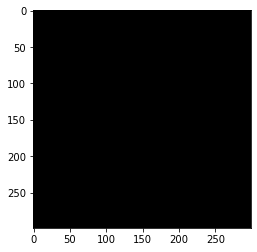

In [52]:
plt.imshow(recognized_image/255.)
#plt.imshow(global_var_img/255.)
best_captions_list 